In [1]:
library(pheatmap, warn.conflicts = F, quietly = T)
library(ggplot2, warn.conflicts = F, quietly = T)
library(DESeq2, warn.conflicts = F, quietly = T)
library(apeglm, warn.conflicts = F, quietly = T)

Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”

Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Warning message:
“package ‘matrixStats’ was built under R version 4.1.3”

Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
  

In [43]:
metadata <- read.table("../03-diff_abundance/map.txt", header=T, sep="\t")
row.names(metadata) <- metadata$sample_id
genecounts <- read.table("strep_species_counts_for_deseq.txt", header=T, sep="\t", row.names = 1)
# fix sample names gene count file
colnames(genecounts) <- gsub(x = names(genecounts), pattern = "X", replacement = "UF")  

In [44]:
# only compare PD to PF
metadata <- metadata[metadata$tooth_type != "PE",]
# only keep columns found in metadata
genecounts <- genecounts[, colnames(genecounts) %in% row.names(metadata)]
# reorder by metadata rownames
metadata <- metadata[order(colnames(genecounts)),]
# colnames(genecounts)
# rownames(metadata)
# create deseq object
star_results <- DESeqDataSetFromMatrix(countData = genecounts, colData = metadata, design = ~tooth_type)
# filter out any genes with fewer than 10 reads total
star_results <- star_results[rowSums(counts(star_results)) >= 10,]
star_results
# set factor level (this determines which direction the comparisions are made -- by default it's by alphabetical order)
star_results$tooth_type <- factor(star_results$tooth_type, levels=c("PD", "PF"))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 14 60 
metadata(1): version
assays(1): counts
rownames(14): Streptococcus_anginosus Streptococcus_australis ...
  Streptococcus_sp._HMT_056 Streptococcus_sp._HMT_066
rowData names(0):
colnames(60): UF106PFR UF10PD ... UF87PFR UF8PF
colData names(10): sample_id tooth_type ... ads_nmol_min_mg_of_protein
  concentration_ng_ul

In [45]:
se_star <- DESeq(star_results)
norm_counts <- log2(counts(se_star, normalized = TRUE)+1)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 8 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [46]:
res <- results(se_star, alpha=0.05)
# order by p value
res <- res[order(res$padj),]
paste("number of genes with adjusted p value lower than 0.05: ", sum(res$padj < 0.05, na.rm=TRUE))
summary(res)
resultsNames(se_star)

[1] "number of genes with adjusted p value lower than 0.05:  6"


out of 14 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2, 14%
LFC < 0 (down)     : 4, 29%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



[1] "Intercept"           "tooth_type_PF_vs_PD"

In [47]:
# filter out low count genes
resLFC <- lfcShrink(se_star, coef="tooth_type_PF_vs_PD", type="apeglm")
resLFC <- resLFC[order(resLFC$padj),]
paste("number of genes with adjusted p value lower than 0.05: ", sum(resLFC$padj < 0.05, na.rm=TRUE))
summary(resLFC)
# write results to file
write.table(resLFC, file="deseq_results.txt", quote=F, sep="\t")

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] "number of genes with adjusted p value lower than 0.05:  6"


out of 14 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 3, 21%
LFC < 0 (down)     : 5, 36%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



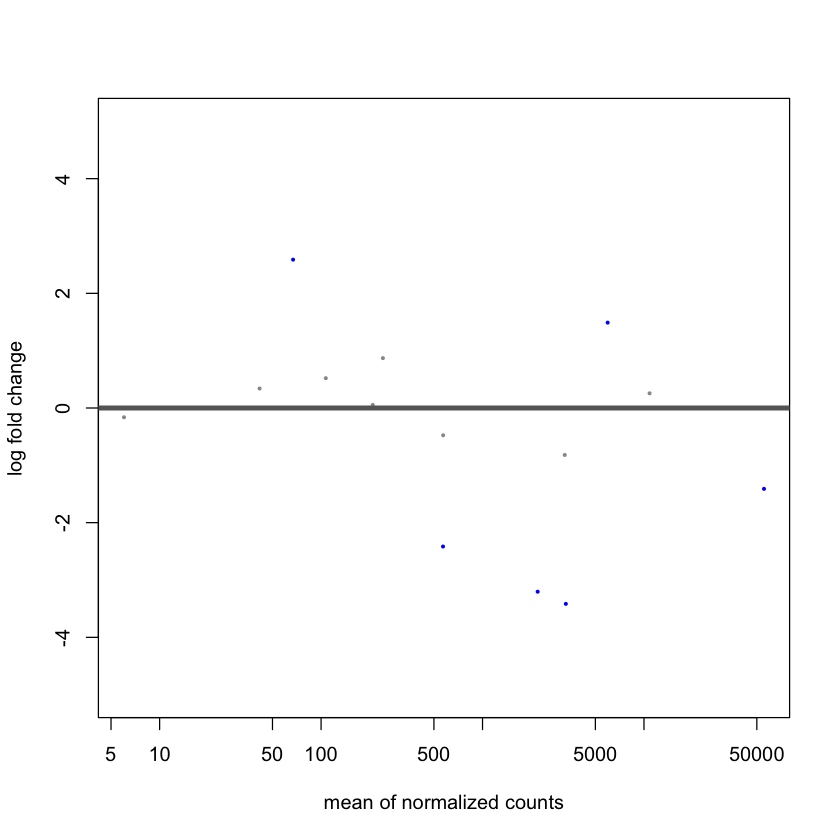

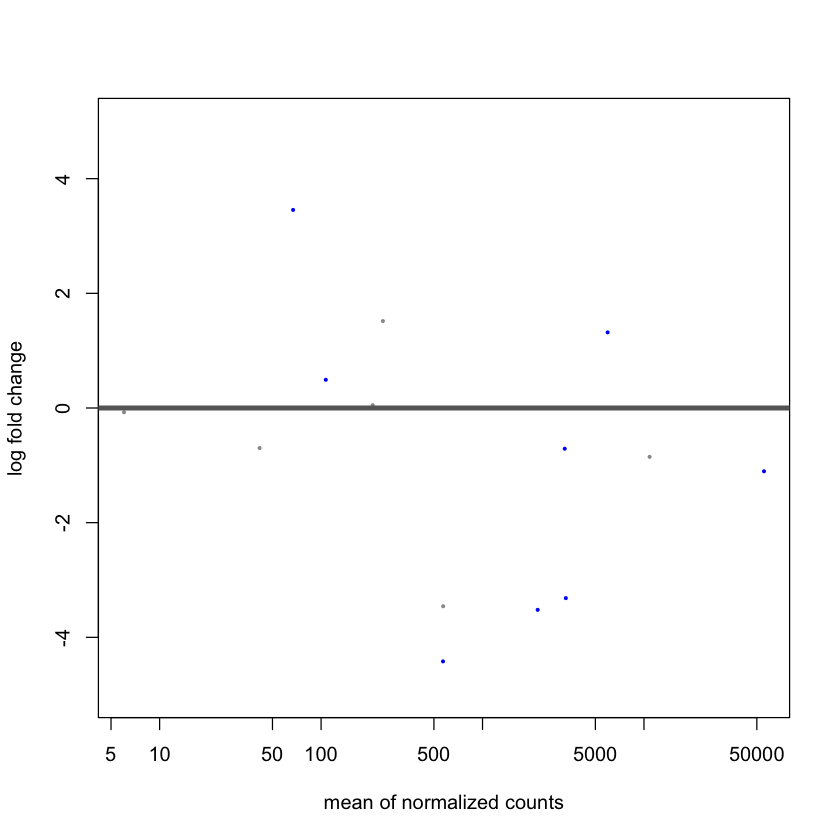

In [48]:
volcano_all <- plotMA(res, ylim=c(-5,5))
plotMA(res, ylim=c(-5,5))
volcano_flat <- plotMA(resLFC, ylim=c(-5,5))
plotMA(resLFC, ylim=c(-5,5))

In [49]:
# transform for visualizations
vld <- varianceStabilizingTransformation(se_star)

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.



pdf 
  2

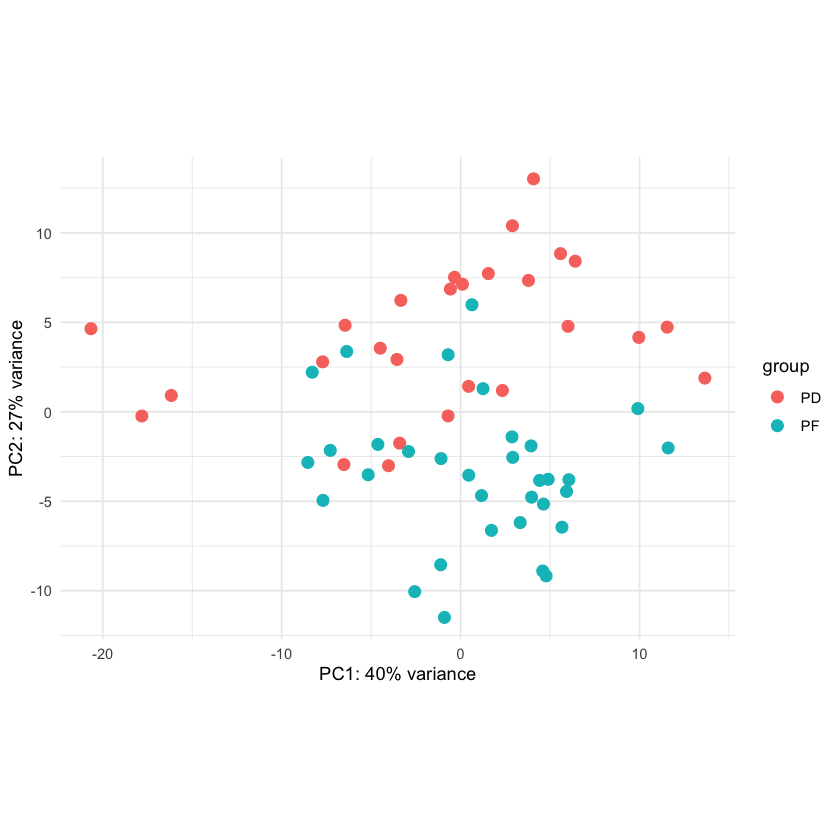

In [50]:
#Get top varying genes
topVarGenes <- head(order(rowVars(assay(vld)), decreasing=TRUE), 50)
 
#make a subset of the log transformed counts for just the top 25 varying genes
topCounts <- assay(vld)[topVarGenes,]
write.csv(topCounts, file="topcounts.vld.csv", quote=FALSE)
 
#PLOT PCA
#PCA using top 500 varying genes
pdf("pca_pdvpf.pdf")
plotPCA(vld, intgroup=c("tooth_type"), ntop=500) + theme_minimal()
dev.off()
plotPCA(vld, intgroup=c("tooth_type"), ntop=500) + theme_minimal()

pdf 
  2

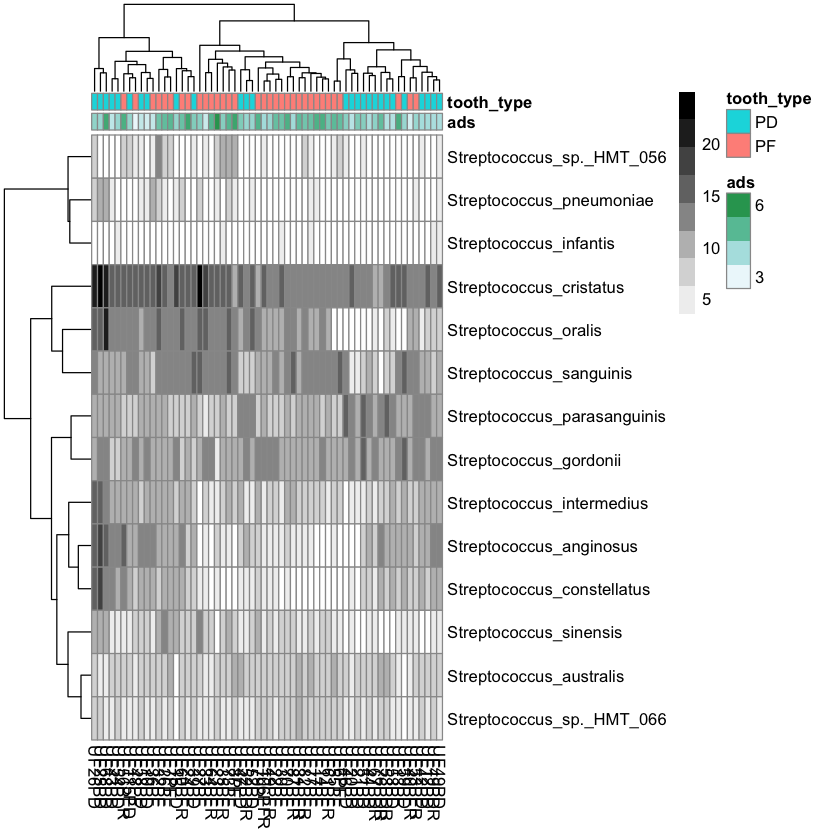

In [56]:
df <- as.data.frame(colData(vld)[,c("ads_nmol_min_mg_of_protein","tooth_type")])
df$ads_nmol_min_mg_of_protein <- log2(as.numeric(df$ads_nmol_min_mg_of_protein))
colnames(df) <- c("ads", "tooth_type")

save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
library(RColorBrewer)
x <- pheatmap(topCounts, annotation_col = df, color = brewer.pal(9, "Greys"))
save_pheatmap_pdf(x, "heatmap_strepADSpdvpf.pdf")

In [52]:
# donut plots
library(webr)
library(ggplot2)

,Genus,Tooth_type,Count
,<chr>,<chr>,<int>
1,Actinomyces,PD,36329
2,Bulleidia,PD,1291
3,Cryptobacterium,PD,2969
4,Cutibacterium,PD,3322
5,Fusobacterium,PD,469
6,Kingella,PD,35685


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


pdf 
  2

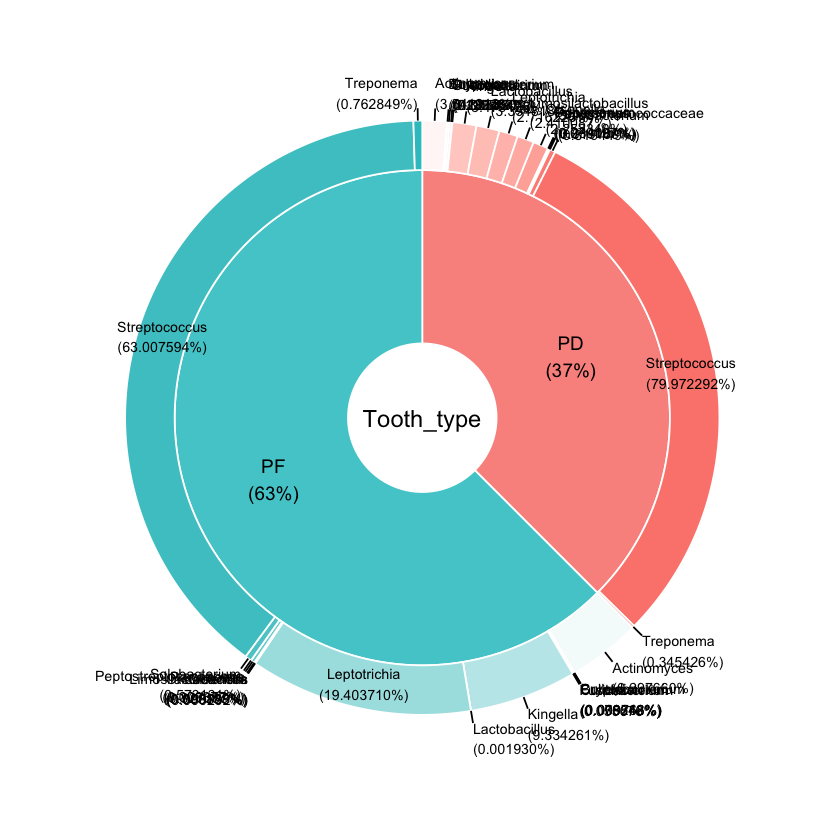

In [57]:
tax_count <- read.delim("genus_counts_donutplots.txt")
head(tax_count)
PieDonut(tax_count, aes("Tooth_type", "Genus", count="Count"), showRatioThreshold = F)
pdf("genus_ads_donutplot.pdf")
PieDonut(tax_count, aes("Tooth_type", "Genus", count="Count"), showRatioThreshold = F)
dev.off()

,Species,Tooth_type,Count
,<chr>,<chr>,<int>
1,Streptococcus_anginosus,PD,79020
2,Streptococcus_australis,PD,18304
3,Streptococcus_constellatus,PD,26410
4,Streptococcus_cristatus,PD,54732
5,Streptococcus_gordonii,PD,157771
6,Streptococcus_infantis,PD,208


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


pdf 
  2

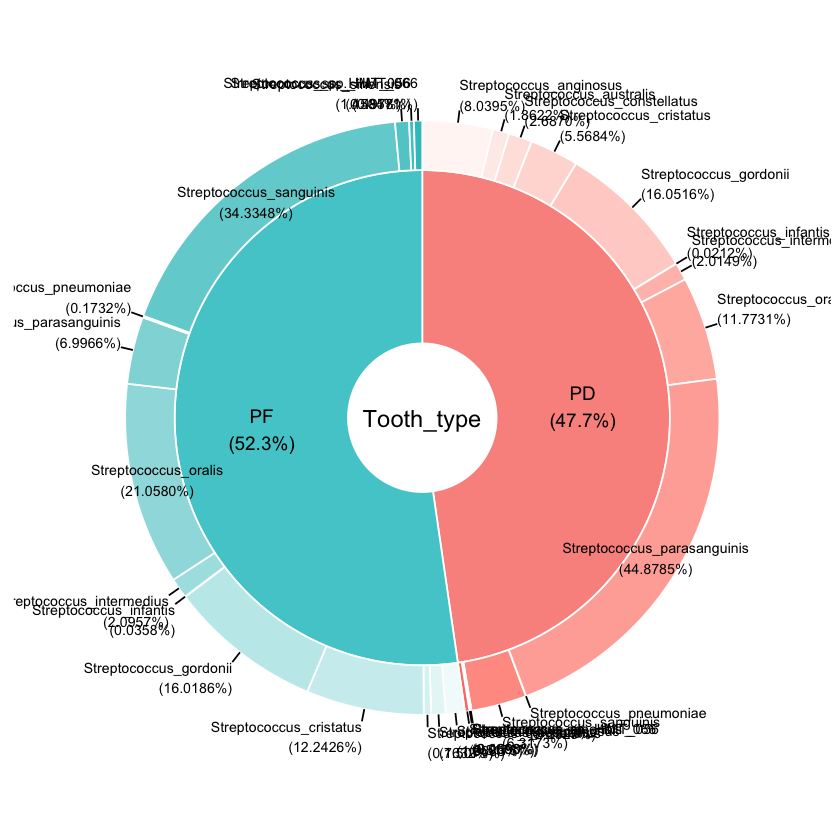

In [58]:
# donut plot of strep species
tax_count <- read.delim("strep_species_donut.txt")
head(tax_count)
PieDonut(tax_count, aes("Tooth_type", "Species", count="Count"), showRatioThreshold = F)
pdf("strep_species_donutplot.pdf")
PieDonut(tax_count, aes("Tooth_type", "Species", count="Count"), showRatioThreshold = F)
dev.off()

,GeneCluster,Tooth_type,Count
,<chr>,<chr>,<int>
1,arcA,PF,581320
2,arcB/F,PF,708412
3,arcC1,PF,376226
4,arcC2,PF,22799
5,arcD,PF,17691
6,arcA,PD,522412


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


pdf 
  2

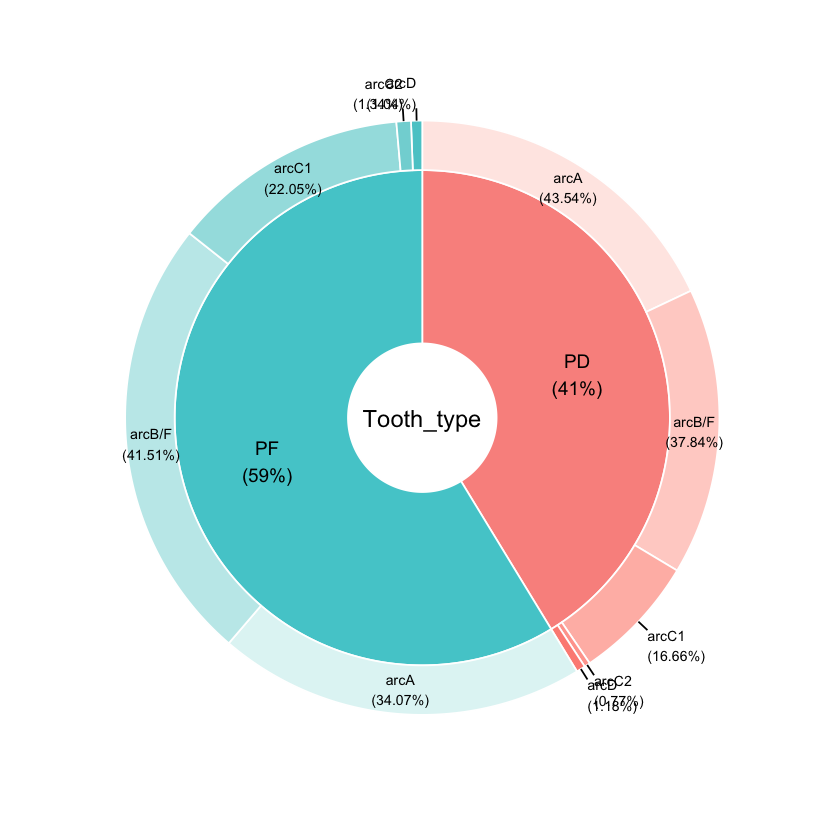

In [59]:
tax_count <- read.delim("gene_count_donut.txt")
head(tax_count)
PieDonut(tax_count, aes("Tooth_type", "GeneCluster", count="Count"), showRatioThreshold = F)
pdf("genecluster_donutplot.pdf")
PieDonut(tax_count, aes("Tooth_type", "GeneCluster", count="Count"), showRatioThreshold = F)
dev.off()